In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip /content/drive/My\ Drive/Mask/dataset.zip

Archive:  /content/drive/My Drive/Mask/dataset.zip
   creating: dataset/
   creating: dataset/without_mask/
  inflating: dataset/without_mask/0.jpg  
  inflating: dataset/without_mask/1.jpg  
  inflating: dataset/without_mask/10.jpg  
  inflating: dataset/without_mask/100.jpg  
  inflating: dataset/without_mask/101.jpg  
  inflating: dataset/without_mask/102.jpg  
  inflating: dataset/without_mask/104.jpg  
  inflating: dataset/without_mask/105.jpg  
  inflating: dataset/without_mask/106.jpg  
  inflating: dataset/without_mask/107.jpg  
  inflating: dataset/without_mask/108.jpg  
  inflating: dataset/without_mask/109.jpg  
  inflating: dataset/without_mask/11.jpg  
  inflating: dataset/without_mask/110.jpg  
  inflating: dataset/without_mask/111.jpg  
  inflating: dataset/without_mask/112.jpg  
  inflating: dataset/without_mask/114.jpg  
  inflating: dataset/without_mask/115.jpg  
  inflating: dataset/without_mask/116.jpg  
  inflating: dataset/without_mask/117.jpg  
  inflating: datas

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation, BatchNormalization, Dropout, MaxPooling2D, AveragePooling2D, Dropout, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [ ]:
imagePaths = list(paths.list_images("dataset"))
data = []
labels = []

In [ ]:
# image paths
for imagePath in imagePaths:
	# get labels from path
	label = imagePath.split(os.path.sep)[-2]

	# preprocessing
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	data.append(image)
	labels.append(label)

In [ ]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

# one-hot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# 1st

In [ ]:
base1 = MobileNetV2(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3))

head1 = base1.output
head1 = AveragePooling2D(pool_size=(7, 7))(head1)
head1 = Flatten(name="flatten")(head1)
head1 = Dense(128, activation="relu")(head1)
head1 = Dropout(0.5)(head1)
head1 = Dense(2, activation="softmax")(head1)
model1 = Model(inputs=base1.input, outputs=head1)

for layer in base1.layers:
	layer.trainable = False

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model1.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
H = model1.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/20
34/34 [==============================] - 11s 316ms/step - loss: 0.4591 - accuracy: 0.7949 - val_loss: 0.0881 - val_accuracy: 0.9783
Epoch 2/20
34/34 [==============================] - 10s 299ms/step - loss: 0.1065 - accuracy: 0.9642 - val_loss: 0.0472 - val_accuracy: 0.9855
Epoch 3/20
34/34 [==============================] - 10s 297ms/step - loss: 0.0683 - accuracy: 0.9794 - val_loss: 0.0367 - val_accuracy: 0.9891
Epoch 4/20
34/34 [==============================] - 10s 294ms/step - loss: 0.0550 - accuracy: 0.9878 - val_loss: 0.0299 - val_accuracy: 0.9928
Epoch 5/20
34/34 [==============================] - 10s 296ms/step - loss: 0.0414 - accuracy: 0.9888 - val_loss: 0.0274 - val_accuracy: 0.9928
Epoch 6/20
34/34 [==============================] - 10s 296ms/step - loss: 0.0337 - accuracy: 0.9934 - val_loss: 0.0226 - val_accuracy: 0.9928
Epoch 7/20
34/34 [==============================] - 10s 295ms/step - loss: 0.0281 - accuracy: 0.9906 - val_loss: 0.0212 - val_accuracy: 0.9928

In [ ]:
predIdxs = model1.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       138
without_mask       0.99      0.99      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



In [ ]:
model1.save("/content/model.h5", save_format="h5")

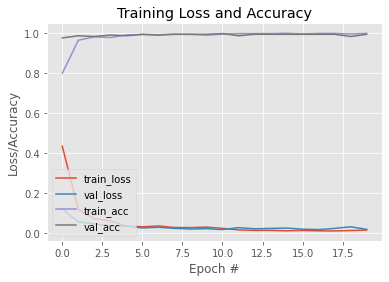

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('model.jpg')

# 2nd

In [ ]:
input2 = Input(shape=(224,224,3))  

# 1st Conv
hidden2 = Conv2D(64, (3,3), padding="valid")(input2)
hidden2 = BatchNormalization()(hidden2)
hidden2 = Activation('relu')(hidden2)
hidden2 = MaxPooling2D(pool_size=(2, 2))(hidden2)
hidden2 = Dropout(0.25)(hidden2)

# 2nd Conv
hidden2 = Conv2D(128, (5,5), padding="valid")(hidden2)
hidden2 = BatchNormalization()(hidden2)
hidden2 = Activation('relu')(hidden2)
hidden2 = MaxPooling2D(pool_size=(2, 2))(hidden2)
hidden2 = Dropout(0.25)(hidden2)

# Flattening
hidden2 = Flatten()(hidden2)

# Fully connected layer layer
hidden2 = Dense(256)(hidden2)
hidden2 = BatchNormalization()(hidden2)
hidden2 = Activation('relu')(hidden2)
hidden2 = Dropout(0.25)(hidden2)

output2 = Dense(2, activation='softmax')(hidden2)

# Create the model
model2 = Model(inputs=input2, outputs=output2)

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model2.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
batch_normalization_3 (Batch (None, 222, 222, 64)      256       
_________________________________________________________________
activation_3 (Activation)    (None, 222, 222, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 107, 107, 128)     2049

In [ ]:
H2 = model2.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/20
34/34 [==============================] - 13s 371ms/step - loss: 0.6355 - accuracy: 0.8202 - val_loss: 0.3318 - val_accuracy: 0.8478
Epoch 2/20
34/34 [==============================] - 12s 366ms/step - loss: 0.3237 - accuracy: 0.9017 - val_loss: 0.4986 - val_accuracy: 0.6993
Epoch 3/20
34/34 [==============================] - 13s 372ms/step - loss: 0.2265 - accuracy: 0.9223 - val_loss: 0.9061 - val_accuracy: 0.5000
Epoch 4/20
34/34 [==============================] - 12s 364ms/step - loss: 0.1959 - accuracy: 0.9354 - val_loss: 0.6262 - val_accuracy: 0.5652
Epoch 5/20
34/34 [==============================] - 12s 363ms/step - loss: 0.2166 - accuracy: 0.9232 - val_loss: 0.7886 - val_accuracy: 0.5036
Epoch 6/20
34/34 [==============================] - 12s 361ms/step - loss: 0.1406 - accuracy: 0.9476 - val_loss: 0.9089 - val_accuracy: 0.5145
Epoch 7/20
34/34 [==============================] - 12s 362ms/step - loss: 0.1315 - accuracy: 0.9494 - val_loss: 0.8267 - val_accuracy: 0.5109

In [ ]:
predIdxs = model2.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.97      0.98       138
without_mask       0.97      0.99      0.98       138

    accuracy                           0.98       276
   macro avg       0.98      0.98      0.98       276
weighted avg       0.98      0.98      0.98       276

